In [1]:
from mimic.utilities.utilities import set_all_seeds
from mimic.utilities.utilities import plot_gMLV
from mimic.model_infer import *
from mimic.model_simulate import *
import pandas as pd


import numpy as np


import matplotlib.pyplot as plt


from scipy.integrate import odeint


from numpy import linalg as la

import sklearn.linear_model


from sklearn.linear_model import LinearRegression


from sklearn.linear_model import Ridge


from sklearn.linear_model import Lasso


from sklearn.linear_model import ElasticNet, ElasticNetCV


from sklearn.model_selection import RepeatedKFold


from sklearn.model_selection import cross_val_score


from sklearn.model_selection import KFold


from sklearn.model_selection import GridSearchCV


import sys


sys.path.append("../../")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Simulate some time course data from the gMLV

### Five species, six metabolites, single time course

This model assumes metabolite production is associated with abundance:  dS/dt = alpha X <br>
Note that this model needs rethinking as it cannot handle negative productivities <br>
In this simple example we don't need to infer the time course. We just linearize and estimate the elements of alpha with Lasso<br>
Number of metabolites is 6 here

Using the following parameters for gMLV simulation: {'num_species': 5, 'num_metabolites': 6, 'num_perturbations': 0, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.1 ,  0.  ,  0.05,  0.  ],
       [ 0.  ,  0.  , -0.15,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.01,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.2 ]]), 'beta': array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.5,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ]]), 'epsilon': array([], shape=(5, 0), dtype=float64)}


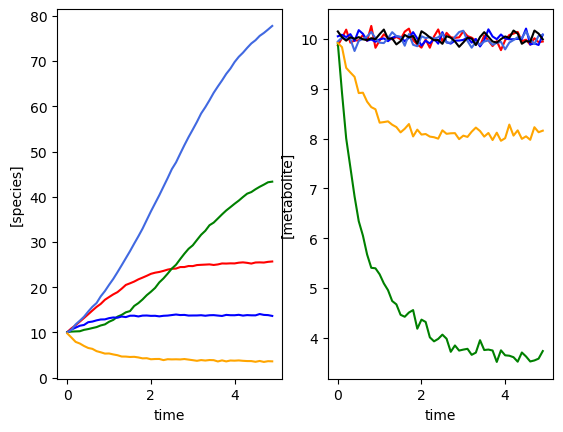

In [2]:
# Simulate some microbiota and metabolites
set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 6

# construct interaction matrix
# TODO do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
# M[0,2] = -0.025
M[1, 3] = 0.05
# M[4,0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct metabolite production matrix
alpha = np.zeros((num_metabolites, num_species))
alpha[1, 4] = 1
alpha[4, 2] = -0.5

# instantiate simulator
simulator = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu,
                     beta=alpha)
# simulator.print()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, _, _, _ = simulator.simulate(
    times=times, sy0=np.hstack((init_species, init_metabolites)))

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
plot_gMLV(yobs, sobs, times)

In [3]:
simulator.print_parameters()

Model parameters:
Model: gMLV
num_species: 5
num_metabolites: 6
num_perturbations: 0
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.    0.    0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.    0.    0.    0.   -0.2 ]]
beta: [[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0. ]]
epsilon: []


In [4]:
simulator.mu

array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068])

In [5]:
simulator.save_parameters("simulator_parameters.json")

In [6]:
simulator.read_parameters("simulator_parameters.json")

In [7]:
simulator.print_parameters()

Model parameters:
Model: gMLV
num_species: 5
num_metabolites: 6
num_perturbations: 0
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.    0.    0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.    0.    0.    0.   -0.2 ]]
beta: [[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0. ]]
epsilon: []


### Five species, single time course, with a perturbation

Model parameters:
Model: gMLV
num_species: 5
num_metabolites: 0
num_perturbations: 1
mu: [1.28 0.56 2.07 0.86 0.7 ]
M: [[-0.05  0.   -0.03  0.    0.  ]
 [ 0.   -0.1   0.    0.05  0.  ]
 [ 0.    0.   -0.15  0.    0.  ]
 [ 0.    0.    0.   -0.01  0.  ]
 [ 0.02  0.    0.    0.   -0.2 ]]
beta: None
epsilon: [[ 0.]
 [-1.]
 [ 0.]
 [-1.]
 [ 0.]]
Using the following parameters for gMLV simulation: {'num_species': 5, 'num_metabolites': 0, 'num_perturbations': 1, 'mu': array([1.27853844, 0.55683415, 2.06752757, 0.86387608, 0.70448068]), 'M': array([[-0.05 ,  0.   , -0.025,  0.   ,  0.   ],
       [ 0.   , -0.1  ,  0.   ,  0.05 ,  0.   ],
       [ 0.   ,  0.   , -0.15 ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.01 ,  0.   ],
       [ 0.02 ,  0.   ,  0.   ,  0.   , -0.2  ]]), 'beta': None, 'epsilon': array([[ 0.],
       [-1.],
       [ 0.],
       [-1.],
       [ 0.]])}


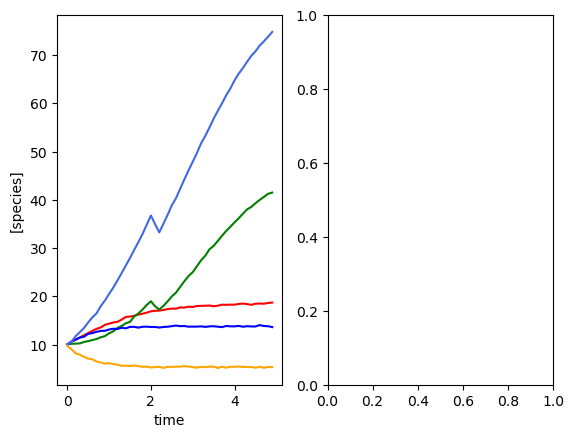

In [10]:
set_all_seeds(1234)

# SETUP MODEL
# establish size of model
num_species = 5
num_metabolites = 0

# construct interaction matrix
# TODO #49 do this programmatically
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2])
M[0, 2] = -0.025
M[1, 3] = 0.05
M[4, 0] = 0.02

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct perturbation matrix
npert = 1
epsilon = np.zeros([num_species, npert])
epsilon[:, 0] = [0, -1, 0, -1, 0]

# instantiate simulator
simulator = sim_gMLV(num_species=num_species,
                     num_metabolites=num_metabolites,
                     num_perturbations=npert,
                     M=M,
                     mu=mu,
                     epsilon=epsilon)
simulator.print_parameters()

# PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

# perturbation information encoded in a function


def pert_fn(t):
    return np.array([1]) if 2.0 <= t < 2.2 else np.array([0])


times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times,
                                               sy0=np.hstack(
                                                   (init_species, init_metabolites)),
                                               u=pert_fn)


# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape)

# plot simulation
plot_gMLV(yobs, sobs, times)